Import bibliotek i konfiguracja środowiska

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Sprawdzanie dostępności różnych akceleratorów
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Używam: NVIDIA CUDA")
elif hasattr(torch, 'xpu') and torch.xpu.is_available():
    device = torch.device('xpu')
    print("Używam: INTEL XPU (Arc/iGPU/NPU)")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Używam: APPLE MPS")
else:
    device = torch.device('cpu')
    print("Używam: CPU")

print(f"Wybrane urządzenie: {device}")

# Ustalenie ziarna losowości dla powtarzalności wyników
torch.manual_seed(42)

Używam: CPU
Wybrane urządzenie: cpu


Przygotowanie danych (Augmentacja i Normalizacja)

In [11]:
# Hiperparametry (wstępne)
batch_size = 64

# Transformacje dla zbioru treningowego (Augmentacja + Normalizacja)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),      # Losowe odbicie poziome
    transforms.RandomCrop(32, padding=4),   # Losowe przycięcie z paddingiem
    transforms.ToTensor(),                  # Zamiana na tensor PyTorch
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Średnia i odchylenie std dla CIFAR-10
])

# Transformacje dla zbioru testowego (Tylko Normalizacja)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Pobranie i ładowanie zbiorów danych
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Klasy w CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Definicja Prostego Modelu Konwolucyjnego (CNN)

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Warstwa konwolucyjna 1: Wejście 3 kanały, wyjście 32, kernel 3x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Warstwa konwolucyjna 2: Wejście 32 kanały, wyjście 64, kernel 3x3
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Warstwy w pełni połączone
        # Obraz 32x32 po dwóch poolingach (dzielenie przez 2 dwukrotnie) ma wymiar 8x8.
        # Zatem wejście do FC to: 64 kanały * 8 * 8
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10) # 10 klas wyjściowych

        self.relu = nn.ReLU()

    def forward(self, x):
        # Conv1 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv1(x)))
        # Conv2 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv2(x)))

        # Spłaszczenie tensora (Flatten) do wektora
        x = x.view(-1, 64 * 8 * 8)

        # FC1 -> ReLU
        x = self.relu(self.fc1(x))
        # FC2 (Logits)
        x = self.fc2(x)
        return x

# Inicjalizacja modelu i przeniesienie na urządzenie
model = SimpleCNN().to(device)

Funkcja Straty i Optymalizator

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Learning rate to hiperparametr

Pętla Treningowa i Ewaluacja

In [ ]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train() # Przełączenie w tryb treningu
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zerowanie gradientów
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass i optymalizacja
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Obliczanie średniej straty na epokę
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Ewaluacja na zbiorze testowym
        model.eval() # Przełączenie w tryb ewaluacji
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        print(f'Epoka [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}, Dokładność (Test): {accuracy:.2f}%')

    return train_losses, test_accuracies

# Uruchomienie treningu
print("Rozpoczynam trening modelu bazowego...")
train_losses, test_accuracies = train_and_evaluate(model, trainloader, testloader, criterion, optimizer, epochs=10)
print("Trening zakończony.")

Rozpoczynam trening modelu bazowego...


Wizualizacja Wyników

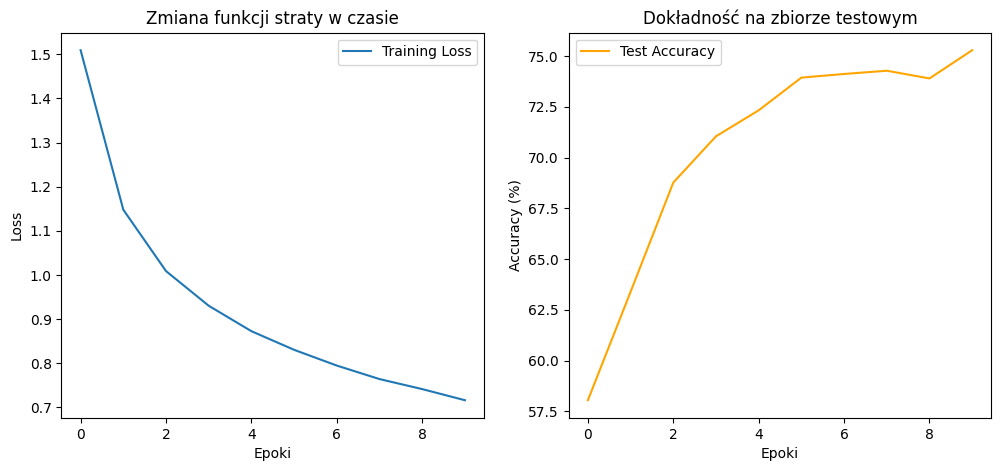

In [6]:
plt.figure(figsize=(12, 5))

# Wykres straty (Loss)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Zmiana funkcji straty w czasie')
plt.xlabel('Epoki')
plt.ylabel('Loss')
plt.legend()

# Wykres dokładności (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.title('Dokładność na zbiorze testowym')
plt.xlabel('Epoki')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

Dostosowanie Hiperparametrów (Tuning)

In [7]:
# 1. Nowa instancja modelu (reset wag)
tuned_model = SimpleCNN().to(device)

# 2. Zmiana hiperparametrów
# Zmniejszamy learning rate z 0.001 na 0.0005
# Dodajemy weight_decay (L2 regularization) aby zapobiec overfittingowi
new_lr = 0.0005
weight_decay = 1e-4

tuned_optimizer = optim.Adam(tuned_model.parameters(), lr=new_lr, weight_decay=weight_decay)

# 3. Ponowny trening z nowymi ustawieniami (więcej epok)
print(f"\nRozpoczynam trening modelu dostrojonego (LR={new_lr}, WD={weight_decay})...")
tuned_losses, tuned_accuracies = train_and_evaluate(
    tuned_model, trainloader, testloader, criterion, tuned_optimizer, epochs=15
)


Rozpoczynam trening modelu dostrojonego (LR=0.0005, WD=0.0001)...
Epoka [1/15], Loss: 1.5142, Dokładność (Test): 59.33%
Epoka [2/15], Loss: 1.1765, Dokładność (Test): 64.97%
Epoka [3/15], Loss: 1.0323, Dokładność (Test): 66.64%
Epoka [4/15], Loss: 0.9519, Dokładność (Test): 69.13%
Epoka [5/15], Loss: 0.8876, Dokładność (Test): 71.63%


KeyboardInterrupt: 